# Sedov-Taylor Blast Wave

This is another problem that demonstrates the ability of the code to handle creation and propagation of shocks. Specifically, we inject a large amount of energy into a single point at the center of a homogeneous gas – for example, one can imagine the detonation of an explosive. The strength of the resulting explosion will produce a spherical shock wave that propagates outwards and once this shock has moved to a large distance (so the only relevant parameter is the strength of the explosion, or, equivalently, the energy injected), we can describe the flow of gas around the shock using the Euler equations. In particular, the region around the shock is well described by the Rankine-Hugoniot shock jump conditions and a series of substitutions into the Euler equations (in spherical coordinates, as [here](https://en.wikipedia.org/wiki/Taylor%E2%80%93von_Neumann%E2%80%93Sedov_blast_wave#Self-similar_solution)) yields an analytic self-similar solution. From this, we get a maximum density compression (over the uniform background density) of 
$$\frac{\rho_\mathrm{max}}{\rho} = \frac{\gamma+1}{\gamma-1}$$
Physically, we expect that the mass is swept up into a thin region immediately behind the shock front, creating a cavity behind the shock that grows as the shock propagates outwards.

### In the Code
Much of the setup in the code is similar to the preceding few example/test problems – we define a method to create the particle container and initialize the different modules of the simulation. Specifically, here, we can see how the code can be used in three dimensions, a natural extension of the 2D setup we had before.

In [1]:
import phd
import numpy as np

We create a grid of particles with resolution $45\times 45\times 45$, set the background density to be $\rho = 1$ and the pressure to be $P = 10^{-6}(\gamma - 1)$.

In [4]:
def create_particles(dim=3, nx=45, Lx=1.0, gamma=1.4):

    dx = Lx/nx # spacing between particles
    n = nx**3  # number of points

    # create particle container
    particles = phd.HydroParticleCreator(n, dim=3)
    part = 0
    np.random.seed(0)
    for i in range(nx):
        for j in range(nx):
            for k in range(nx):
                particles["position-x"][part] = (i+0.5)*dx + 1.0e-8*dx*np.random.rand()
                particles["position-y"][part] = (j+0.5)*dx + 1.0e-8*dx*np.random.rand()
                particles["position-z"][part] = (k+0.5)*dx + 1.0e-8*dx*np.random.rand()
                particles["ids"][part] = part
                part += 1

    # set ambient values
    particles["density"][:]  = 1.0               # density
    particles["pressure"][:] = 1.0E-6*(gamma-1)  # total energy
    particles["velocity-x"][:] = 0.0
    particles["velocity-y"][:] = 0.0
    particles["velocity-z"][:] = 0.0

    # put all energy in center particle
    r = dx * .51
    cell = ((particles["position-x"]-.5)**2 +\
             (particles["position-y"]-.5)**2 +\
             (particles["position-z"]-.5)**2) <= r**2

    particles["pressure"][cell] = 1.0/(dx*dx*dx)*(gamma-1)

    return particles

In [10]:
dim = 3; gamma = 5./3.
particles = phd.distribute_initial_particles(
        create_particles, dim=dim, gamma=gamma)

# computation related to boundaries
domain_manager = phd.DomainManager(
        xmin=[0., 0., 0.], xmax=[1., 1., 1.],
        initial_radius=0.1)

# create voronoi mesh
mesh = phd.Mesh()

# computation
integrator = phd.MovingMeshMUSCLHancock()
integrator.set_mesh(mesh)
integrator.set_riemann(phd.HLLC())
integrator.set_particles(particles)
integrator.set_domain_manager(domain_manager)
integrator.set_boundary_condition(phd.Reflective())
integrator.set_reconstruction(phd.PieceWiseLinear())
integrator.set_equation_state(phd.IdealGas(gamma=gamma))

sim_name = "sedov"
if phd._in_parallel:
    integrator.set_load_balance(phd.LoadBalance())
    sim_name = "mpi_sedov"

# add finish criteria
simulation_time_manager = phd.SimulationTimeManager()
simulation_time_manager.add_finish(phd.Time(time_max=0.06))

# output every time interval
output = phd.TimeInterval(time_interval=0.01)
output.set_writer(phd.Hdf5())
simulation_time_manager.add_output(output)

# output last step
output = phd.FinalOutput()
output.set_writer(phd.Hdf5())
simulation_time_manager.add_output(output)

# Create simulator
simulation = phd.Simulation(simulation_name=sim_name)
simulation.set_integrator(integrator)
simulation.set_simulation_time_manager(simulation_time_manager)
simulation.initialize()
simulation.solve()

phd: [WARNING  ] 2021-06-02 12:09:22,658: Directory sedov_output already exists, files maybe over written!
phd: [WARNING  ] 2021-06-02 12:09:22,661: Directory sedov_output/final_output already exists, files maybe over written!
phd: [INFO     ] 2021-06-02 12:09:22,662: 

 __________.__         .___
\______   \  |__    __| _/
 |     ___/  |  \  / __ |
 |    |   |   Y  \/ /_/ |
 |____|   |___|  /\____ |
               \/      \/
Welcome to Python Hydro-Dynamics!

Simulation Information
------------------------------
Running in serial
Log file saved at: sedov.log
Problem solving: sedov
Output data will be saved at: sedov_output

Classes used in the simulation
------------------------------
boundary_condition: Reflective
domain_manager: DomainManager
equation_state: IdealGas
integrator: MovingMeshMUSCLHancock
mesh: Mesh
particles: CarrayContainer
reconstruction: PieceWiseLinear
riemann: HLLC

phd: [INFO     ] 2021-06-02 12:09:22,663: IntegrateBase: Building initial mesh
phd: [INFO     ] 202

phd: [INFO     ] 2021-06-02 12:10:14,031: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:10:14,151: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:10:17,401: Hydro dt: 0.000079
phd: [INFO     ] 2021-06-02 12:10:17,401: Starting iteration: 10 time: 0.000436 dt: 0.000079
phd: [INFO     ] 2021-06-02 12:10:17,402: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:10:17,653: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:10:18,604: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:10:18,863: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:10:19,039: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:10:19,160: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:10:22,457: Hydro dt: 0.000081
phd: [INFO     ] 2021-06-02 12:10:22,459: Starting iteration: 11 time: 0.000515 dt: 0.000081
phd: [INFO     ] 2021-06-02 12:10:22,459: MovingMeshMUSCLHanco

phd: [INFO     ] 2021-06-02 12:11:14,141: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:11:14,394: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:11:15,348: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:11:15,608: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:11:15,769: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:11:15,891: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:11:19,295: Hydro dt: 0.000151
phd: [INFO     ] 2021-06-02 12:11:19,295: Starting iteration: 22 time: 0.001826 dt: 0.000151
phd: [INFO     ] 2021-06-02 12:11:19,296: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:11:19,553: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:11:20,504: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:11:20,761: PieceWiseLinear: Starting temporal reconstru

phd: [INFO     ] 2021-06-02 12:12:11,089: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:12:11,247: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:12:11,365: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:12:14,630: Hydro dt: 0.000216
phd: [INFO     ] 2021-06-02 12:12:14,631: Starting iteration: 33 time: 0.003832 dt: 0.000216
phd: [INFO     ] 2021-06-02 12:12:14,631: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:12:14,881: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:12:15,827: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:12:16,084: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:12:16,241: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:12:16,360: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:12:19,593: Hydro dt: 0.000221
phd: [INFO     ] 2021-06-02 12:12:19,594: Starting iteration: 3

phd: [INFO     ] 2021-06-02 12:13:10,893: Starting iteration: 44 time: 0.006503 dt: 0.000276
phd: [INFO     ] 2021-06-02 12:13:10,893: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:13:11,150: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:13:12,129: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:13:12,388: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:13:12,550: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:13:12,668: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:13:15,955: Hydro dt: 0.000281
phd: [INFO     ] 2021-06-02 12:13:15,956: Starting iteration: 45 time: 0.006779 dt: 0.000281
phd: [INFO     ] 2021-06-02 12:13:15,956: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:13:16,211: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:13:17,162: PieceWiseLinear: Starting spatial reconstr

phd: [INFO     ] 2021-06-02 12:14:07,778: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:14:08,039: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:14:08,196: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:14:08,316: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:14:12,215: hdf5 format: Writting time_interval0000.hdf5
phd: [INFO     ] 2021-06-02 12:14:12,312: Hydro dt: 0.000342
phd: [INFO     ] 2021-06-02 12:14:12,322: Starting iteration: 56 time: 0.010000 dt: 0.000342
phd: [INFO     ] 2021-06-02 12:14:12,322: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:14:12,611: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:14:13,580: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:14:13,849: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:14:14,008: HLLC: Starting riemann
phd: [INFO     ] 

phd: [INFO     ] 2021-06-02 12:15:08,081: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:15:08,203: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:15:11,554: Hydro dt: 0.000405
phd: [INFO     ] 2021-06-02 12:15:11,555: Starting iteration: 67 time: 0.014080 dt: 0.000405
phd: [INFO     ] 2021-06-02 12:15:11,555: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:15:11,847: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:15:12,835: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:15:13,094: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:15:13,288: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:15:13,406: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:15:16,892: Hydro dt: 0.000411
phd: [INFO     ] 2021-06-02 12:15:16,892: Starting iteration: 68 time: 0.014485 dt: 0.000411
phd: [INFO     ] 2021-06-02 12:15:16,893: MovingMeshMUSCLHanco

phd: [INFO     ] 2021-06-02 12:16:07,835: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:16:08,088: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:16:09,039: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:16:09,298: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:16:09,458: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:16:09,578: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:16:12,871: Hydro dt: 0.000468
phd: [INFO     ] 2021-06-02 12:16:12,871: Starting iteration: 79 time: 0.019295 dt: 0.000468
phd: [INFO     ] 2021-06-02 12:16:12,872: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:16:13,129: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:16:14,082: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:16:14,343: PieceWiseLinear: Starting temporal reconstru

phd: [INFO     ] 2021-06-02 12:17:06,151: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:17:06,407: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:17:06,567: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:17:06,688: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:17:10,101: Hydro dt: 0.000518
phd: [INFO     ] 2021-06-02 12:17:10,102: Starting iteration: 90 time: 0.024451 dt: 0.000518
phd: [INFO     ] 2021-06-02 12:17:10,103: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:17:10,359: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:17:11,311: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:17:11,564: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:17:11,729: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:17:11,857: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:17

phd: [INFO     ] 2021-06-02 12:18:02,276: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:18:05,593: hdf5 format: Writting time_interval0002.hdf5
phd: [INFO     ] 2021-06-02 12:18:05,644: Hydro dt: 0.000567
phd: [INFO     ] 2021-06-02 12:18:05,645: Starting iteration: 101 time: 0.030000 dt: 0.000567
phd: [INFO     ] 2021-06-02 12:18:05,646: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:18:05,906: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:18:06,863: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:18:07,119: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:18:07,279: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:18:07,401: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:18:10,746: Hydro dt: 0.000571
phd: [INFO     ] 2021-06-02 12:18:10,747: Starting iteration: 102 time: 0.030567 dt: 0.000571
phd: [INFO     ] 2021-06-02 12:18:10,7

phd: [INFO     ] 2021-06-02 12:19:02,986: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:19:03,238: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:19:04,198: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:19:04,452: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:19:04,610: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:19:04,732: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:19:08,055: Hydro dt: 0.000620
phd: [INFO     ] 2021-06-02 12:19:08,056: Starting iteration: 113 time: 0.037099 dt: 0.000620
phd: [INFO     ] 2021-06-02 12:19:08,056: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:19:08,312: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:19:09,262: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:19:09,520: PieceWiseLinear: Starting temporal reconstr

phd: [INFO     ] 2021-06-02 12:19:59,717: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:19:59,980: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:20:00,148: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:20:00,271: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:20:03,633: Hydro dt: 0.000662
phd: [INFO     ] 2021-06-02 12:20:03,635: Starting iteration: 124 time: 0.043890 dt: 0.000662
phd: [INFO     ] 2021-06-02 12:20:03,635: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:20:03,884: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:20:04,843: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:20:05,097: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:20:05,254: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:20:05,374: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:2

phd: [INFO     ] 2021-06-02 12:20:55,873: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:20:55,999: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:20:59,246: Hydro dt: 0.000700
phd: [INFO     ] 2021-06-02 12:20:59,247: Starting iteration: 135 time: 0.050696 dt: 0.000700
phd: [INFO     ] 2021-06-02 12:20:59,247: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:20:59,497: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:21:00,461: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:21:00,713: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:21:00,869: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:21:00,989: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:21:04,248: Hydro dt: 0.000704
phd: [INFO     ] 2021-06-02 12:21:04,249: Starting iteration: 136 time: 0.051396 dt: 0.000704
phd: [INFO     ] 2021-06-02 12:21:04,250: MovingMeshMUSCLHan

phd: [INFO     ] 2021-06-02 12:21:54,850: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:21:55,105: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:21:56,056: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:21:56,311: PieceWiseLinear: Starting temporal reconstruction
phd: [INFO     ] 2021-06-02 12:21:56,473: HLLC: Starting riemann
phd: [INFO     ] 2021-06-02 12:21:56,600: Mesh: Starting mesh creation
phd: [INFO     ] 2021-06-02 12:21:59,910: Hydro dt: 0.000745
phd: [INFO     ] 2021-06-02 12:21:59,910: Starting iteration: 147 time: 0.059344 dt: 0.000656
phd: [INFO     ] 2021-06-02 12:21:59,911: MovingMeshMUSCLHancock: Starting integration
phd: [INFO     ] 2021-06-02 12:22:00,164: PieceWiseLinear: Starting gradient cacluation
phd: [INFO     ] 2021-06-02 12:22:01,161: PieceWiseLinear: Starting spatial reconstruction
phd: [INFO     ] 2021-06-02 12:22:01,424: PieceWiseLinear: Starting temporal reconstr

phd: [INFO     ] 2021-06-02 12:04:25,077: hdf5 format: Reading filename sedov_output/final_output/final_output0000/final_output0000.hdf5


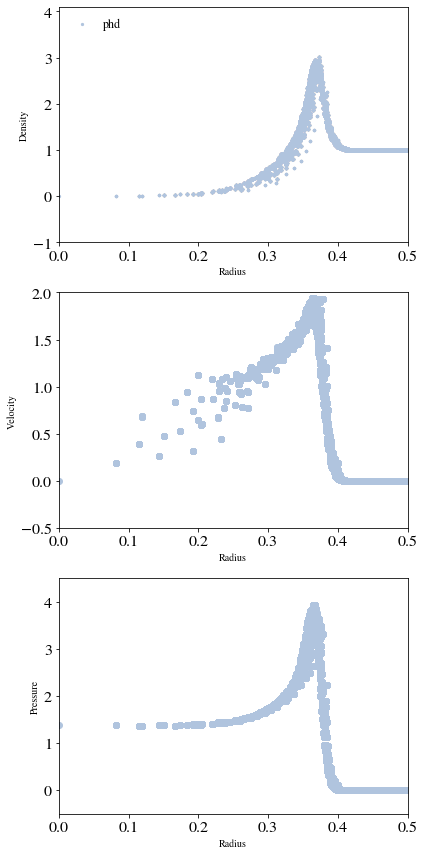

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"
mpl.rcParams["xtick.labelsize"] = 16
mpl.rcParams["ytick.labelsize"] = 16

# plot cartesian or uniform run
file_name="sedov_output/final_output/final_output0000/final_output0000.hdf5"
reader = phd.Hdf5()
sedov = reader.read(file_name)
sedov.remove_tagged_particles(phd.ParticleTAGS.Ghost)

r = np.sqrt((sedov["position-x"]-0.5)**2 + (sedov["position-y"]-0.5)**2 + (sedov["position-z"]-0.5)**2)
v = np.sqrt(sedov["velocity-x"]**2 + sedov["velocity-y"]**2 + sedov["velocity-z"]**2)

# get the exact solution
#exact = np.loadtxt("sedov_3d.dat")

# get the exact solution
#x_ex = exact[:,1]   # radius
#r_ex = exact[:,2]   # density
#p_ex = exact[:,4]   # pressure
#u_ex = exact[:,5]   # velocity

plt.figure(figsize=(6,12))
plt.subplot(3,1,1)
plt.scatter(r, sedov["density"], color="lightsteelblue", label="phd", s= 5)
#plt.plot(x_ex, r_ex, "k", label="exact")
plt.xlim(0,0.5)
plt.ylim(-1,4.1)
plt.xlabel("Radius")
plt.ylabel("Density")
l = plt.legend(loc="upper left", prop={"size":12})
l.draw_frame(False)

plt.subplot(3,1,2)
plt.scatter(r, v, color="lightsteelblue")
#plt.plot(x_ex, u_ex, "k")
plt.xlim(0,0.5)
plt.ylim(-0.5,2.0)
plt.xlabel("Radius")
plt.ylabel("Velocity")

plt.subplot(3,1,3)
plt.scatter(r, sedov["pressure"], color="lightsteelblue")
#plt.plot(x_ex, p_ex, "k")
plt.xlim(0,0.5)
plt.ylim(-0.5,4.5)
plt.xlabel("Radius")
plt.ylabel("Pressure")

plt.tight_layout()
plt.savefig("sedov_3d.png")
plt.show()